In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Import libraries

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [8]:
from scipy.spatial import distance

In [9]:
pd.options.mode.chained_assignment = None

# Read data from file

In [10]:
path = r"C:\Users\Admins\Programming\Foundation of Data Science Projects\SCMission-2023_Round-3-Data-Đã clean.xlsm"

### Customer data

In [11]:
customer_df = pd.read_excel(path, sheet_name = 'Customer_Master')
customer_df = customer_df.drop(['SoldToCode', 'SoldToName', 'MajorAccount',
                               'MajorAccountCode', 'MajorAccountCode.1',
                               'Channel', 'SubChannel', 'City', 'State', 
                                'Country', 'SalesOrganization', 'Region'], axis=1)
print(customer_df.shape)
customer_df.head()

(314, 5)


,STT,CustomerRef,CustomerName,Longitude,Latitude
0,1,11000128,Customer 48,145.206237,-38.025962
1,2,11000144,Customer 50,144.947676,-37.728991
2,3,11000149,Customer 51,152.519049,-32.197687
3,4,11000159,Customer 52,153.122555,-27.617230
4,5,11000176,Customer 53,145.197119,-37.990926


### Order data (2021-2022)

In [12]:
order_df = pd.read_excel(path, sheet_name = 'Sales_Order')
order_df = order_df.drop(['OriginRef', 'Legit?', 'DeliveryDate',
                         'GoodsIssueDate', 'RequestedDelivDate', 'Channel',
                         'SalesOrganization', 'DispatchQuantityInKg', 'NetWeightInKg', 
                          'Unnamed: 16', 'Unnamed: 17'], axis=1)

date1 = pd.Series(pd.date_range(
    start=pd.to_datetime(order_df['SOCreationDate'].iloc[0]),
    end=pd.to_datetime(order_df['SOCreationDate'].iloc[-1]) + pd.DateOffset(days=1),
    freq='W'
))
week_df = pd.DataFrame({'date_given': date1})
week_df['StartDate'] = week_df['date_given'].dt.to_period('W').dt.start_time
week_df['EndDate'] = week_df['date_given'].dt.to_period('W').dt.end_time

week_df['Week'] = 'Week' + (week_df.reset_index().index + 1).astype(str)

order_df['Week'] = "Week"

for i in range(week_df.shape[0]):
    order_df['Week'][order_df['SOCreationDate'].between(
                    week_df['StartDate'][i], 
                    week_df['EndDate'][i]
    )] = i + 1
    
print(order_df.shape)
order_df.head()

(28680, 8)


,STT,SOCreationDate,OrderNumber,ProductID,CustomerRef,OrderQuantityInKg,GrossWeightInKg,Week
0,1,2021-08-02,5233870,3110685,14019842,57224.8944,58697.5260,1
1,2,2021-08-02,5233874,3110678,14019842,77232.0384,79387.7568,1
2,3,2021-08-02,5233877,3103449,14019842,13387.6800,13732.2000,1
3,4,2021-08-02,5233877,3103450,14019842,2380.0320,2446.4640,1
4,5,2021-08-02,5234064,3110656,11002626,7147.0080,7330.7520,1


### Order data (2022)

In [13]:
order_df_2022 = order_df[order_df['SOCreationDate'].dt.year == 2022].reset_index(drop=True)
print(order_df_2022.shape)
order_df_2022.head()

(20374, 8)


,STT,SOCreationDate,OrderNumber,ProductID,CustomerRef,OrderQuantityInKg,GrossWeightInKg,Week
0,8307,2022-01-01,5406460,3110656,11002626,9529.344,9774.336,22
1,8308,2022-01-01,5406460,3110678,11002626,36890.496,37920.192,22
2,8309,2022-01-01,5406460,3110685,11002626,19040.256,19530.240,22
3,8310,2022-01-01,5406460,3110687,11002626,13102.848,13468.224,22
4,8311,2022-01-01,5406471,3110656,11002626,8338.176,8552.544,22


### Facilities data

In [14]:
facilities_df = pd.read_excel(path, sheet_name = 'Data_Master', skiprows=53, nrows=7)
facilities_df = facilities_df.drop(['Address', 'Street', 'Suburb', 
                    'Postcode', 'City', 'State', 
                    'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
                    'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'], axis=1)
print(facilities_df.shape)
facilities_df

(6, 6)


,FacilityRef,FacilityName,Type,StorageCapacityInPallet,Longitude,Latitude
0,A093,Facility 4,DC,48000,144.751154,-37.781694
1,A093,Facility 4,DC,48000,144.746868,-37.798232
2,A093,Facility 4,DC,24000,144.746868,-37.798232
3,A019,Facility 5,DC,42000,144.837577,-37.840767
4,A044,Facility 9,Plant,1200,143.064535,-38.327400
5,A044,Facility 9,Plant,600,143.064488,-38.327407


### DC Facilites data

In [15]:
dc_facilities_df = facilities_df[facilities_df['Type']=='DC']
dc_facilities_df

,FacilityRef,FacilityName,Type,StorageCapacityInPallet,Longitude,Latitude
0,A093,Facility 4,DC,48000,144.751154,-37.781694
1,A093,Facility 4,DC,48000,144.746868,-37.798232
2,A093,Facility 4,DC,24000,144.746868,-37.798232
3,A019,Facility 5,DC,42000,144.837577,-37.840767


### Plant Facilities data

In [16]:
plant_facilities_df = facilities_df[facilities_df['Type']=='Plant'].reset_index(drop=True)
plant_facilities_df

,FacilityRef,FacilityName,Type,StorageCapacityInPallet,Longitude,Latitude
0,A044,Facility 9,Plant,1200,143.064535,-38.327400
1,A044,Facility 9,Plant,600,143.064488,-38.327407


### Packing data

In [17]:
def turning(types):
    if types == 'Carton':
        return "CTN"
    elif types == "Glass Bottle":
        return "GBOT"
    elif types == "Plastic Bottle":
        return 'PBOT'

In [18]:
packing = pd.read_excel(path, sheet_name = "Data_Master", skiprows = 41, nrows = 10)
packing = packing.ffill()
dropped = packing.dropna(axis = 1)
packing = dropped.rename(columns = {
    'Unnamed: 0': 'Types',
    'Unnamed: 1': 'Volumes',
    'Unnamed: 2': 'Weights',
})
packing['Types(Unit)'] = packing['Types'].apply(turning)
print(packing.shape)
packing

(9, 6)


,Types,Volumes,Weights,Recycled content,Virgin content,Types(Unit)
0,Carton,400G,40,0.57,0.7,CTN
1,Carton,15ML,5,0.57,0.7,CTN
2,Carton,250ML,25,0.57,0.7,CTN
3,Carton,1L,50,0.57,0.7,CTN
4,Plastic Bottle,300ML,15,1.70,3.1,PBOT
5,Plastic Bottle,600ML,25,1.70,3.1,PBOT
6,Glass Bottle,1L,500,0.55,1.2,GBOT
7,Glass Bottle,2L,1000,0.55,1.2,GBOT
8,Glass Bottle,3L,1500,0.55,1.2,GBOT


### Product data 

In [19]:
data_df = pd.read_excel(path, sheet_name = 'Data_Master',skiprows = 1, nrows = 38)
data_df = data_df.drop(['ProductName', 'Category', 'SubCategory', 'BaseUnit', 'ShelfLifeInDays',
                       'StorageCondition', 'TempCondition', 
                       'Unnamed: 17', 'Unnamed: 18'], axis=1)
print(data_df.shape)
data_df.head()

(38, 10)


,STT,ProductID,KgPerCarton,KgPerLiter,m^3PerCarton,KgPerPallet,CartonsPerPallet,Unit,UnitperCarton,Type
0,1,3110922.0,9.297,1.033,0.013,929.7,100.0,GBOT,9.0,1L
1,2,3113090.0,4.800,1.000,0.015,403.2,84.0,CTN,12.0,400G
2,3,3112144.0,3.600,1.000,0.012,345.6,96.0,CTN,9.0,400G
3,4,116052.0,12.144,1.012,0.015,910.8,75.0,CTN,12.0,1L
4,5,115532.0,12.348,1.029,0.015,926.1,75.0,CTN,12.0,1L


### Collection point data 

In [20]:
collection_point_df = pd.read_excel(path, sheet_name = 'Data_Master',skiprows = 62, nrows = 4)
collection_point_df = collection_point_df.drop(['Unnamed: 6', 'Unnamed: 7', 
                                                'Unnamed: 8', 'Unnamed: 9', 
                                                'Unnamed: 10', 'Unnamed: 11',
                                                'Unnamed: 12', 'Unnamed: 13', 
                                                'Unnamed: 14','Unnamed: 15', 
                                                'Unnamed: 16', 'Unnamed: 17', 
                                                'Unnamed: 18'], axis=1)
collection_point_df = collection_point_df.ffill()
print(collection_point_df.shape)
collection_point_df.head()

(3, 6)


,Size,Number of Pallet,Annual Pallet Cost ($),Overflow Cost ($/pallet/day),Energy Consumption (kWh/pallet/year),CO2 emissions (kgCO2e/kWh)
0,Small,70,7000,3.0,2.4,0.371
1,Medium,230,23000,3.0,2.4,0.371
2,Big,1100,110000,3.0,2.4,0.371


# Filter data for clustering

### Sum order in of customer

In [21]:
sum_order = order_df.groupby(['CustomerRef'])['GrossWeightInKg'].sum().reset_index()
sum_order = sum_order.rename(columns={'GrossWeightInKg': 'SumGrossWeightInKg'})
print(sum_order.shape)
sum_order.head()

(314, 2)


,CustomerRef,SumGrossWeightInKg
0,11000128,89342.7756
1,11000144,5758.9296
2,11000149,5356.7184
3,11000159,252.7776
4,11000176,2960.0172


### Combine customers' location with facilities' locations

In [22]:
# calculating the distance from each customer to each kind ò 
dist_dc = distance.cdist(customer_df[["Longitude", "Latitude"]], 
                         dc_facilities_df[["Longitude", "Latitude"]])
print(dist_dc.shape)
customer_df["nearest_dc"] = np.argmin(dist_dc, axis=1)

dist_plant = distance.cdist(customer_df[["Longitude", "Latitude"]], 
                         plant_facilities_df[["Longitude", "Latitude"]])
print(dist_plant.shape)
customer_df["nearest_plant"] = np.argmin(dist_plant, axis=1)

(314, 4)
(314, 2)


In [23]:
bine_df = pd.merge(customer_df, dc_facilities_df, 
                   left_on="nearest_dc", right_index=True, suffixes=("Customer", "FacilityDC"))
bine_df = pd.merge(bine_df, plant_facilities_df, 
                   left_on="nearest_plant", right_index=True, suffixes=("", "FacilityPlant"))

In [24]:
customer_and_facility_location = bine_df[['CustomerRef','CustomerName', 
                                          'LongitudeCustomer', 'LatitudeCustomer', 
                                          'FacilityName', 
                                          'LongitudeFacilityDC', 'LatitudeFacilityDC',
                                         'Longitude', 'Latitude']]
customer_and_facility_location = customer_and_facility_location.rename(columns={
    'Longitude': 'LongitudeFacilityPlant',
    'Latitude': 'LatitudeFacilityPlant'
})
customer_and_facility_location.head()

,CustomerRef,CustomerName,LongitudeCustomer,LatitudeCustomer,FacilityName,LongitudeFacilityDC,LatitudeFacilityDC,LongitudeFacilityPlant,LatitudeFacilityPlant
0,11000128,Customer 48,145.206237,-38.025962,Facility 5,144.837577,-37.840767,143.064535,-38.3274
1,11000144,Customer 50,144.947676,-37.728991,Facility 5,144.837577,-37.840767,143.064535,-38.3274
2,11000149,Customer 51,152.519049,-32.197687,Facility 5,144.837577,-37.840767,143.064535,-38.3274
3,11000159,Customer 52,153.122555,-27.617230,Facility 5,144.837577,-37.840767,143.064535,-38.3274
4,11000176,Customer 53,145.197119,-37.990926,Facility 5,144.837577,-37.840767,143.064535,-38.3274


### Filtered out features need for clustering

In [25]:
features = pd.merge(customer_and_facility_location, sum_order, on = "CustomerRef")

print(features.shape)
features.head()

(314, 10)


,CustomerRef,CustomerName,LongitudeCustomer,LatitudeCustomer,FacilityName,LongitudeFacilityDC,LatitudeFacilityDC,LongitudeFacilityPlant,LatitudeFacilityPlant,SumGrossWeightInKg
0,11000128,Customer 48,145.206237,-38.025962,Facility 5,144.837577,-37.840767,143.064535,-38.3274,89342.7756
1,11000144,Customer 50,144.947676,-37.728991,Facility 5,144.837577,-37.840767,143.064535,-38.3274,5758.9296
2,11000149,Customer 51,152.519049,-32.197687,Facility 5,144.837577,-37.840767,143.064535,-38.3274,5356.7184
3,11000159,Customer 52,153.122555,-27.617230,Facility 5,144.837577,-37.840767,143.064535,-38.3274,252.7776
4,11000176,Customer 53,145.197119,-37.990926,Facility 5,144.837577,-37.840767,143.064535,-38.3274,2960.0172


# Pipe line for clustering

In [26]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('kmeans', KMeans(init='k-means++', n_init=50, random_state=42))
])

Because we haven't consider the capacity of each dc, plant so we can't make sure that it's okay to use it as features so we don't use it anymore, only 3 main features like the followings.

In [27]:
X = features[['LongitudeCustomer', 'LatitudeCustomer', 
#               'LongitudeFacilityDC', 'LatitudeFacilityDC',  
#               'LongitudeFacilityPlant', 'LatitudeFacilityPlant',
              "SumGrossWeightInKg"]].values

X.shape

(314, 3)

In [28]:
pipe.fit(X)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('kmeans', KMeans(n_init=50, random_state=42))])

### Function for calculating number of pallet per cluster
#### Loop through all the clusters, for each cluster, calculate the number of pallet by deviding total weight of their order (by each kind of product) by weight of that product which a pallet can contain
#### Take the mean of pallet in each week.

In [83]:
def calculate_num_pallet(order_df_, cluster_df, data_df, choose_by='max'):
    data_need = order_df_[['ProductID', 'CustomerRef', 'GrossWeightInKg', 'Week']]
    data_need = pd.merge(data_need, cluster_df[['CustomerRef', 'Cluster']], on='CustomerRef')
    
    num_pallet_per_week_for_each_cluster = []
    cluster_runtime = []
    week_runtime = []
    
    for cluster in range(cluster_df['Cluster'].max()+1):
        for week in range(order_df_['Week'].max()+1):
            filtered_data = data_need[
                (data_need['Week'] == int(week)) & (data_need['Cluster'] == cluster)]
            new_df = filtered_data.groupby('ProductID')['GrossWeightInKg'].sum().reset_index()
            new_df = pd.merge(data_df[['ProductID', 'KgPerPallet']], new_df, on='ProductID')
            new_df['NumPallet'] = new_df['GrossWeightInKg'] / new_df['KgPerPallet']
            num_pallet_per_week_for_each_cluster.append(new_df['NumPallet'].sum())
            cluster_runtime.append(cluster)
            week_runtime.append(week)
            
    num_pallet_per_collection_point = pd.DataFrame()
    num_pallet_per_collection_point['Week'] = week_runtime
    num_pallet_per_collection_point['Cluster'] = cluster_runtime
    num_pallet_per_collection_point['NumPallet'] = num_pallet_per_week_for_each_cluster
    
    if choose_by == 'max':
        num_pallet_per_cluster = num_pallet_per_collection_point.groupby('Cluster')[
            'NumPallet'].max().apply(math.ceil).reset_index()
    elif choose_by == 'mean':
        num_pallet_per_cluster = num_pallet_per_collection_point.groupby('Cluster')[
            'NumPallet'].mean().apply(math.ceil).reset_index()
        
    total_pallet = pd.DataFrame()
    total_pallet['Cluster'] = [i for i in range(cluster_df['Cluster'].max()+1)]
    total_pallet['Number Of Pallets'] = num_pallet_per_cluster['NumPallet']
    
    return total_pallet, num_pallet_per_collection_point[num_pallet_per_collection_point['Week']>=22]

### Function for calculating capacities of collection points
#### Collection points' capacities are calculated in the following way:
* Attemp to get the highest size if possible
* If it raise over the number of pallet needed, attempt to get the smaller size

In [75]:
def cal_collection_point(num_pallets):
    size = {
        'small': 70,
        'medium': 230,
        'big': 1100
    }
    num_collection = {
        'small': 0,
        'medium': 0,
        'big': 0
    }
    initial_using_size = 'big'
    i = 0
    while (True):
        i+=1
        collection_total_pallets = num_collection[
            'small']*70 + num_collection['medium']*230 + num_collection['big']*1100
        if (num_pallets<=collection_total_pallets):
            if initial_using_size == 'big':
                initial_using_size = 'medium'
                num_collection['big'] -= 1
                num_collection[initial_using_size] += 1
            elif initial_using_size == 'medium':
                initial_using_size = 'small'
                num_collection['medium'] -= 1
                num_collection[initial_using_size] += 1
            elif initial_using_size == 'small':
                break
        else:
             num_collection[initial_using_size] += 1
    return [num_collection['small'], num_collection['medium'], num_collection['big']]

### Function for calculate total collection point cost
#### AnnualCost = numberOfSmallCollectionpoint * 7000 dollars + numberOfMediumCollectionpoint * 23000 dollars + numberOfSmallCollectionpoint * 110000 dollars
#### OverflowCost = totalNumberOfPalletOverTheCapacityOfCollectionpoint * 3 dollars * 7 days
#### TotalCost = AnnualCost + OverflowCost

In [76]:
def calulate_cost(numPallet_per_cluster, num_pallet_per_collection_point):
    total_cost = 0
    # Calculate the anual pallet cost
    numPallet_per_cluster['AnualPalletCost'] = numPallet_per_cluster[
        'Small'
    ] * 7_000 + numPallet_per_cluster[
        'Medium'
    ] * 23_000 + numPallet_per_cluster[
        'Big'
    ] * 110_000
    
    total_cost = numPallet_per_cluster['AnualPalletCost'].sum()
    print(f"Annual pallet cost: {total_cost}")
    
    numPallet_per_cluster = numPallet_per_cluster.rename(columns={'Cluster': 'Clusters'})
    num_pallet_per_collection_point = num_pallet_per_collection_point.rename(columns={
        'Cluster': 'Clusters'
    })
    
    # Calculate the overflow cost
    for_overflow_calculating = pd.merge(num_pallet_per_collection_point,
                                       numPallet_per_cluster, on='Clusters')
    overflow_cost = for_overflow_calculating[
        'NumPallet'] - for_overflow_calculating['Number Of Pallets']
    overflow_cost = overflow_cost[overflow_cost < 0].apply(abs).apply(math.ceil )
    print(f"Number of pallets need to be rented: {overflow_cost.sum()}")
    overflow_cost = overflow_cost.sum()*3*7
    
    total_cost += overflow_cost
    
    return total_cost

### Function for Calculate CO2 emissions
#### Energy Consumption = TotalPallets * 2.4 
#### Co2 Emissions = energy consumption * 0.371 

In [77]:
def co2_cal(numPallet_per_cluster):
    total_pallet = numPallet_per_cluster[
    'Small'] * 70 + numPallet_per_cluster[
    'Medium'] * 230 + numPallet_per_cluster[
    'Big'] * 1100

    total_pallet = total_pallet.sum()

    energy_consumption = total_pallet * 2.4
    CO2_cause_by_collection_point = energy_consumption * 0.371 
    
    return CO2_cause_by_collection_point

In [85]:
his_related_cost = list()
numPalletWeekPlot = list()
choose_by = 'mean'

for k_value in list(range(2, 10)):
    print(f"Number of clusters: {k_value}")
    # clustering 
    pipe.named_steps['kmeans'].set_params(n_clusters=k_value)
    pipe.fit(X)
    
    cluster_df = pd.DataFrame()
    cluster_df['CustomerName'] = features['CustomerName']
    cluster_df['CustomerRef'] = features['CustomerRef']
    cluster_df['Cluster'] = pipe.named_steps['kmeans'].labels_
    
    # calculate number of pallet for each cluster
    numPallet_per_cluster, numPalletPerWeek = calculate_num_pallet(order_df_=order_df_2022,
                                                 cluster_df=cluster_df,
                                                 data_df=data_df,
                                                 choose_by=choose_by)
    if k_value == 3:
        numPalletWeekPlot.append(numPalletPerWeek)
    # choosing capacity size for each collection points
    small, medium, big = [], [], []
    for pallet in numPallet_per_cluster['Number Of Pallets'].tolist():
        capacities = cal_collection_point(num_pallets=pallet)
        small.append(capacities[0])
        medium.append(capacities[1])
        big.append(capacities[2])
    numPallet_per_cluster['Small'] = small
    numPallet_per_cluster['Medium'] = medium
    numPallet_per_cluster['Big'] = big
    print(numPallet_per_cluster)
    total_pallet_collectionpoint_has = numPallet_per_cluster[
        'Small'] * 70 + numPallet_per_cluster[
        'Medium'] * 230 + numPallet_per_cluster[
        'Big'] * 1100
    print(f'Total pallet collection point has: {total_pallet_collectionpoint_has.sum()}')
    
    anual_cost = calulate_cost(numPallet_per_cluster=numPallet_per_cluster,
                               num_pallet_per_collection_point=numPalletPerWeek)
    print(f"Total cost: {anual_cost}")
    
    co2 = co2_cal(numPallet_per_cluster=numPallet_per_cluster)
    print(f"CO2 Emissions: {co2}")
    if choose_by == 'mean':
        his_related_cost.append({
            'k_value': k_value,
            'anual_cost_mean': anual_cost,
            'co2_emission': co2
        })
    else: 
        his_related_cost.append({
            'k_value': k_value,
            'anual_cost_max': anual_cost,
            'co2_emission': co2
        })
        
    
    print()

Number of clusters: 2
   Cluster  Number Of Pallets  Small  Medium  Big
0        0               2019      4       3    1
1        1                 30      1       0    0
Total pallet collection point has: 2140
Annual pallet cost: 214000
Number of pallets need to be rented: 1934
Total cost: 254614
CO2 Emissions: 1905.456

Number of clusters: 3
   Cluster  Number Of Pallets  Small  Medium  Big
0        0               1966      3       3    1
1        1                 30      1       0    0
2        2                 54      1       0    0
Total pallet collection point has: 2140
Annual pallet cost: 214000
Number of pallets need to be rented: 1972
Total cost: 255412
CO2 Emissions: 1905.456

Number of clusters: 4
   Cluster  Number Of Pallets  Small  Medium  Big
0        0                 54      1       0    0
1        1               1966      3       3    1
2        2                 28      1       0    0
3        3                  3      1       0    0
Total pallet collection poin

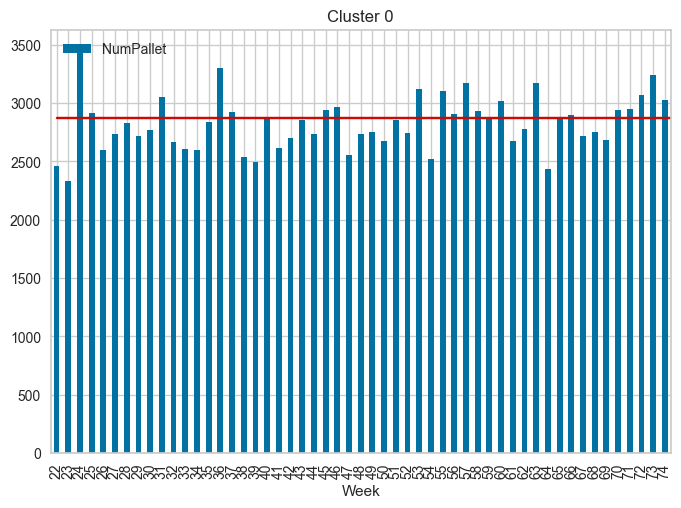

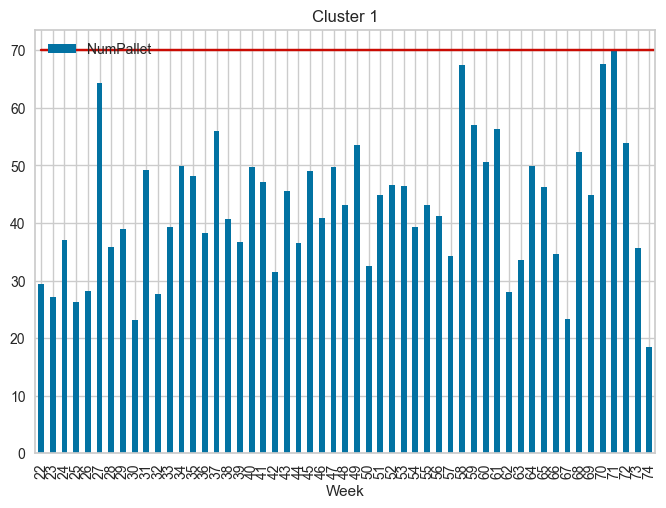

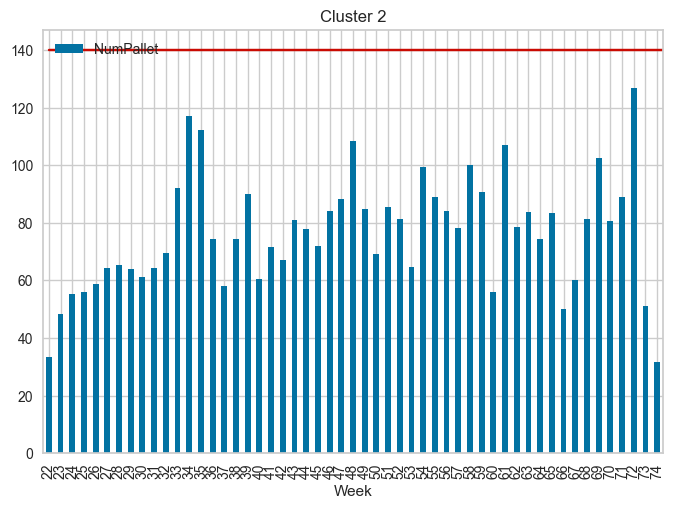

In [79]:
for cluster_name in range(0, 3):
    numPalletWeekPlot[0][numPalletWeekPlot[0]['Cluster']==cluster_name].plot.bar(x='Week', y='NumPallet')
    weeks = [i for i in range(0, 75)]
#     value = [2000, 70, 70]
    value = [2870, 70, 140]
    y = [value[cluster_name] for i in range(0, 75)]
    plt.plot(weeks, y, 'r-')
    plt.title(f'Cluster {cluster_name}')
    plt.legend(loc='upper left')

<Axes: xlabel='k_value', ylabel='anual_cost_mean'>

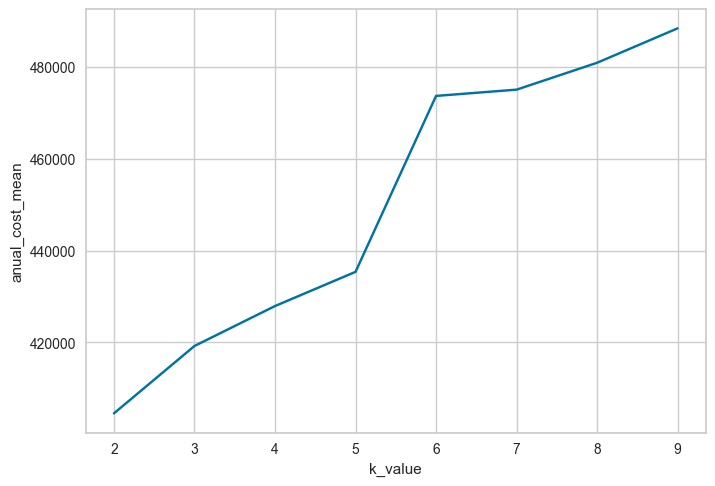

In [80]:
y_name = f"anual_cost_{choose_by}"
his_cost_df = pd.DataFrame(his_related_cost)
sns.lineplot(data=his_cost_df,
            x = 'k_value',
            y=y_name)

<Axes: xlabel='k_value', ylabel='co2_emission'>

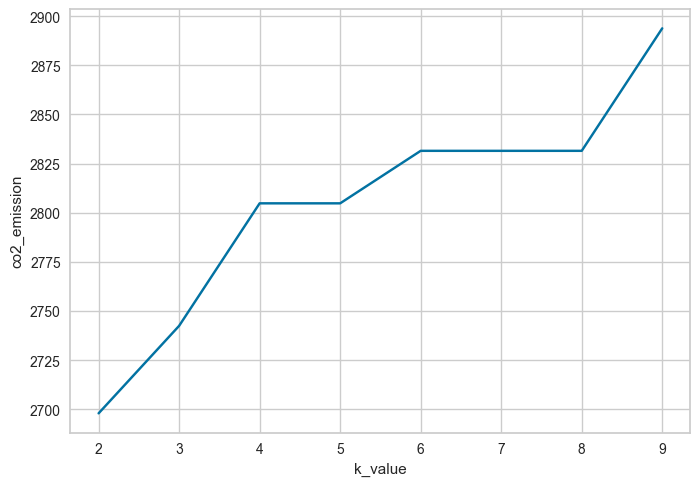

In [81]:
his_cost_df = pd.DataFrame(his_related_cost)
sns.lineplot(data=his_cost_df,
            x = 'k_value',
            y='co2_emission')

In [82]:
print(his_related_cost[1])

{'k_value': 3, 'anual_cost_mean': 419216, 'co2_emission': 2742.432}


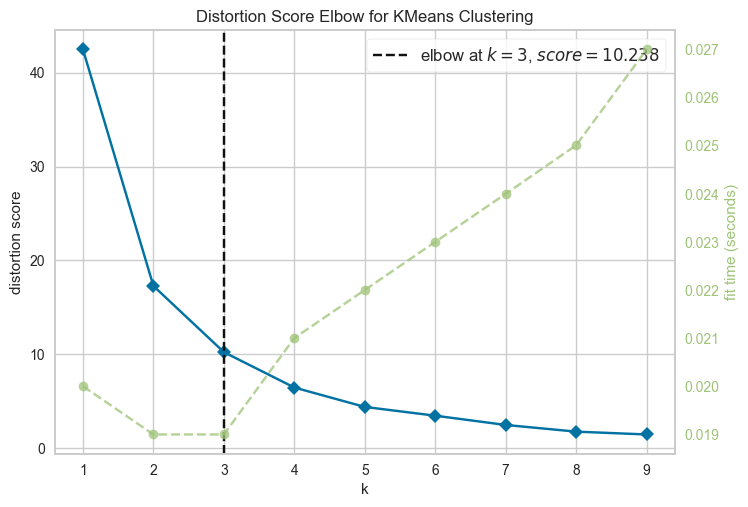

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
model = KMeans(init='k-means++', n_init=10, random_state=42)

# Create KElbowVisualizer
visualizer = KElbowVisualizer(model, k=(1, 10))

# Fit the visualizer with the data
visualizer.fit(pipe.named_steps['scaler'].fit_transform(X))

# Show the elbow plot
visualizer.show()

# Using the most optimal number of clusters to clusters

In [39]:
# k_value = visualizer.elbow_value_
k_value = 3
pipe.named_steps['kmeans'].set_params(n_clusters=k_value)
pipe.fit(X)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('kmeans', KMeans(n_clusters=3, n_init=50, random_state=42))])

In [40]:
cluster_df = pd.DataFrame()
cluster_df['CustomerName'] = features['CustomerName']
cluster_df['CustomerRef'] = features['CustomerRef']
cluster_df['Cluster'] = pipe.named_steps['kmeans'].labels_

print(cluster_df.shape)
cluster_df

(314, 3)


,CustomerName,CustomerRef,Cluster
0,Customer 48,11000128,0
1,Customer 50,11000144,0
2,Customer 51,11000149,0
3,Customer 52,11000159,2
4,Customer 53,11000176,0
...,...,...,...
309,Customer 613,14020819,1
310,Customer 616,14021034,1
311,Customer 826,14021364,1
312,Customer 638,14021786,1


In [41]:
X_plot = pd.merge(cluster_df, features[['CustomerName', 
                                        'LongitudeCustomer', 
                                        'LatitudeCustomer']], on = 'CustomerName')
X_plot

,CustomerName,CustomerRef,Cluster,LongitudeCustomer,LatitudeCustomer
0,Customer 48,11000128,0,145.206237,-38.025962
1,Customer 50,11000144,0,144.947676,-37.728991
2,Customer 51,11000149,0,152.519049,-32.197687
3,Customer 52,11000159,2,153.122555,-27.617230
4,Customer 53,11000176,0,145.197119,-37.990926
...,...,...,...,...,...
309,Customer 613,14020819,1,115.788490,-32.051250
310,Customer 616,14021034,1,115.882853,-31.864786
311,Customer 826,14021364,1,115.650286,-33.338060
312,Customer 638,14021786,1,115.813580,-31.904670


In [42]:
centroids_scaled = pipe.named_steps['kmeans'].cluster_centers_
centroids_scaled

array([[8.23112286e-01, 2.25470545e-01, 7.48554466e-03],
       [1.29084902e-01, 4.92839061e-01, 3.15432625e-04],
       [9.46379894e-01, 5.58826997e-01, 3.42652731e-04]])

In [43]:
centroids = pipe.named_steps['scaler'].inverse_transform(centroids_scaled)
centroids

array([[ 1.46648691e+02, -3.59859428e+01,  1.13229753e+06],
       [ 1.19654430e+02, -2.78536314e+01,  4.77435161e+04],
       [ 1.51443196e+02, -2.58465347e+01,  5.18608403e+04]])

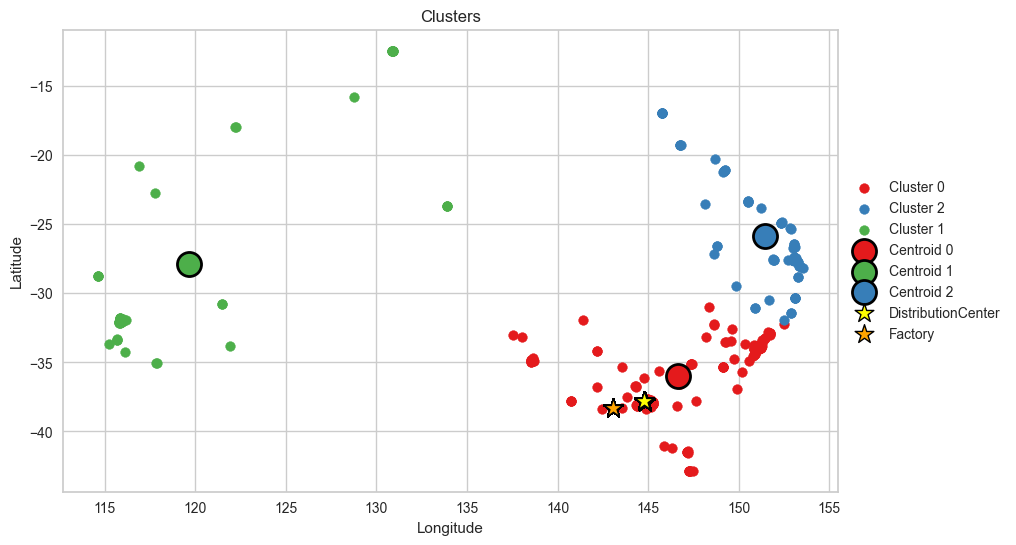

In [44]:
df = X_plot[['Cluster', 'LongitudeCustomer', 'LatitudeCustomer']]
clusters = df['Cluster'].unique()

plt.subplots(figsize=(10, 6))

colors = sns.color_palette('Set1', len(clusters))

cluster_color_map = {cluster: color for cluster, color in zip(clusters, colors)}

for cluster in clusters:
    data = df[df['Cluster'] == cluster]
    plt.scatter(data['LongitudeCustomer'], data['LatitudeCustomer'], 
                color=cluster_color_map[cluster], label=f'Cluster {cluster}')

for i, centroid in enumerate(centroids):
    cluster = i 
    plt.scatter(centroid[0], centroid[1], marker='o', 
                facecolors=cluster_color_map[cluster], edgecolors='black', 
                linewidths=2, s=300, label=f'Centroid {i}')

plt.scatter(features['LongitudeFacilityDC'], features['LatitudeFacilityDC'],
            marker='*', c='yellow', cmap='Set1', s=200, label='DistributionCenter',
            edgecolors='black', 
            linewidths=1)
plt.scatter(features['LongitudeFacilityPlant'], features['LatitudeFacilityPlant'],
            marker='*', c='orange', cmap='Set1', s=200, label='Factory',
            edgecolors='black', 
            linewidths=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [45]:
a, _ = calculate_num_pallet(order_df_=order_df, 
                            cluster_df=cluster_df, 
                            data_df=data_df, 
                            choose_by='mean')
a

,Cluster,Number Of Pallets
0,0,2817
1,1,42
2,2,74


In [46]:
small = list()
medium = list()
big = list()

for pallet in a['Number Of Pallets'].tolist():
    capacities_ = cal_collection_point(num_pallets=pallet)
    small.append(capacities_[0])
    medium.append(capacities_[1])
    big.append(capacities_[2])
a['Small'] = small
a['Medium'] = medium
a['Big'] = big

a

,Cluster,Number Of Pallets,Small,Medium,Big
0,0,2817,3,2,2
1,1,42,1,0,0
2,2,74,2,0,0


# Calculate Circular Inflow

In [47]:
def recycled(unit):
    if unit == 'CTN':
        return 0.57
    elif unit == 'PBOT':
        return 1.7
    elif unit == 'GBOT':
        return 0.55
    else:
        return 0
        
def virgin(unit):
    if unit == 'CTN':
        return 0.7
    elif unit == 'PBOT':
        return 3.1
    elif unit == 'GBOT':
        return 1.2
    else:
        return 0

In [48]:
order_df_2022.head()

,STT,SOCreationDate,OrderNumber,ProductID,CustomerRef,OrderQuantityInKg,GrossWeightInKg,Week
0,8307,2022-01-01,5406460,3110656,11002626,9529.344,9774.336,22
1,8308,2022-01-01,5406460,3110678,11002626,36890.496,37920.192,22
2,8309,2022-01-01,5406460,3110685,11002626,19040.256,19530.240,22
3,8310,2022-01-01,5406460,3110687,11002626,13102.848,13468.224,22
4,8311,2022-01-01,5406471,3110656,11002626,8338.176,8552.544,22


In [49]:
order_df_2022 = pd.merge(order_df_2022, cluster_df, on='CustomerRef', how='left')
order_df_2022.head()

,STT,SOCreationDate,OrderNumber,ProductID,CustomerRef,OrderQuantityInKg,GrossWeightInKg,Week,CustomerName,Cluster
0,8307,2022-01-01,5406460,3110656,11002626,9529.344,9774.336,22,Customer 304,0
1,8308,2022-01-01,5406460,3110678,11002626,36890.496,37920.192,22,Customer 304,0
2,8309,2022-01-01,5406460,3110685,11002626,19040.256,19530.240,22,Customer 304,0
3,8310,2022-01-01,5406460,3110687,11002626,13102.848,13468.224,22,Customer 304,0
4,8311,2022-01-01,5406471,3110656,11002626,8338.176,8552.544,22,Customer 304,0


In [50]:
data_need = order_df_2022[['ProductID', 'CustomerRef', 'GrossWeightInKg',
                           'OrderQuantityInKg', 'Week','Cluster']]
data_need = data_need.merge(data_df[['ProductID', 'Unit']], on='ProductID', how='left')
data_need

,ProductID,CustomerRef,GrossWeightInKg,OrderQuantityInKg,Week,Cluster,Unit
0,3110656,11002626,9774.336,9529.344,22,0,GBOT
1,3110678,11002626,37920.192,36890.496,22,0,GBOT
2,3110685,11002626,19530.240,19040.256,22,0,GBOT
3,3110687,11002626,13468.224,13102.848,22,0,GBOT
4,3110656,11002626,8552.544,8338.176,22,0,GBOT
...,...,...,...,...,...,...,...
20369,3110687,11002626,12243.840,11911.680,74,0,GBOT
20370,3110656,11002626,8552.544,8338.176,74,0,GBOT
20371,3110678,11002626,33027.264,32130.432,74,0,GBOT
20372,3110685,11002626,15868.320,15470.208,74,0,GBOT


In [51]:
order_df_2022.loc[:, "PackageVolume"] = order_df_2022['GrossWeightInKg'] - order_df_2022['OrderQuantityInKg']
order_df_2022

,STT,SOCreationDate,OrderNumber,ProductID,CustomerRef,OrderQuantityInKg,GrossWeightInKg,Week,CustomerName,Cluster,PackageVolume
0,8307,2022-01-01,5406460,3110656,11002626,9529.344,9774.336,22,Customer 304,0,244.992
1,8308,2022-01-01,5406460,3110678,11002626,36890.496,37920.192,22,Customer 304,0,1029.696
2,8309,2022-01-01,5406460,3110685,11002626,19040.256,19530.240,22,Customer 304,0,489.984
3,8310,2022-01-01,5406460,3110687,11002626,13102.848,13468.224,22,Customer 304,0,365.376
4,8311,2022-01-01,5406471,3110656,11002626,8338.176,8552.544,22,Customer 304,0,214.368
...,...,...,...,...,...,...,...,...,...,...,...
20369,28676,2022-12-31,5783479,3110687,11002626,11911.680,12243.840,74,Customer 304,0,332.160
20370,28677,2022-12-31,5783497,3110656,11002626,8338.176,8552.544,74,Customer 304,0,214.368
20371,28678,2022-12-31,5783497,3110678,11002626,32130.432,33027.264,74,Customer 304,0,896.832
20372,28679,2022-12-31,5783497,3110685,11002626,15470.208,15868.320,74,Customer 304,0,398.112


In [52]:
packageVolume = order_df_2022[['PackageVolume']].groupby(order_df_2022['ProductID']).sum().reset_index()

In [53]:
packageVolume = packageVolume.merge(data_df[['ProductID','Unit']],on='ProductID', how='left')
packageVolume

,ProductID,PackageVolume,Unit
0,114528,1.463280e+04,CTN
1,114592,2.075238e+04,CTN
2,115449,8.461471e+03,CTN
3,115532,2.605546e+04,CTN
4,115547,9.101947e+04,CTN
5,115798,1.241848e+04,CTN
6,115906,1.332631e+04,CTN
7,116052,5.135336e+04,CTN
8,121380,8.590926e+04,CTN
9,121412,3.110847e+04,CTN


In [54]:
package_unit = packageVolume[['PackageVolume']].groupby(packageVolume['Unit']).sum().reset_index()
package_unit

,Unit,PackageVolume
0,CTN,5.156046e+05
1,GBOT,3.458379e+06
2,PBOT,3.988095e+05


In [55]:
package_unit['WeightReturn'] = package_unit['PackageVolume']/2

In [56]:
def reycle_rate(unit):
    if unit == 'CTN':
        return 0.7
    elif unit=='GBOT':
        return 1
    else:
        return 0.7
def not_reycle_rate(unit):
    if unit == 'CTN':
        return 0.05
    elif unit=='GBOT':
        return 0
    else:
        return 0.1

In [57]:
package_unit['RecycleRate'] = package_unit['Unit'].apply(reycle_rate)
package_unit['NotRecycleRate'] = package_unit['Unit'].apply(not_reycle_rate)

In [58]:
package_unit['WeightRecycle'] = package_unit.apply(lambda row: row['WeightReturn'] * row['RecycleRate'], axis=1)
package_unit

,Unit,PackageVolume,WeightReturn,RecycleRate,NotRecycleRate,WeightRecycle
0,CTN,5.156046e+05,2.578023e+05,0.7,0.05,1.804616e+05
1,GBOT,3.458379e+06,1.729190e+06,1.0,0.00,1.729190e+06
2,PBOT,3.988095e+05,1.994048e+05,0.7,0.10,1.395833e+05


In [59]:
package_unit['WeightBeforeRecycle'] = package_unit.apply(lambda row: row['WeightReturn'] * row['NotRecycleRate'], axis=1)
package_unit

,Unit,PackageVolume,WeightReturn,RecycleRate,NotRecycleRate,WeightRecycle,WeightBeforeRecycle
0,CTN,5.156046e+05,2.578023e+05,0.7,0.05,1.804616e+05,12890.11620
1,GBOT,3.458379e+06,1.729190e+06,1.0,0.00,1.729190e+06,0.00000
2,PBOT,3.988095e+05,1.994048e+05,0.7,0.10,1.395833e+05,19940.47686


In [60]:
totalCirInflow = (package_unit['WeightRecycle'].sum()/package_unit['WeightReturn'].sum())*100
totalCirInflow

93.72656695088291

# GHG Emissions

In [61]:
def GHG_Emissions(mx,mr,mv,ghgmr,ghrmv):
    return mx*ghgmr - mr*ghgmr - mv*ghrmv

In [62]:
package_unit['WeightVirgin'] = package_unit['WeightReturn'] - package_unit['WeightRecycle']
package_unit['WeightVirginNotRecycle'] = package_unit['WeightReturn'] - package_unit['WeightBeforeRecycle']
package_unit

,Unit,PackageVolume,WeightReturn,RecycleRate,NotRecycleRate,WeightRecycle,WeightBeforeRecycle,WeightVirgin,WeightVirginNotRecycle
0,CTN,5.156046e+05,2.578023e+05,0.7,0.05,1.804616e+05,12890.11620,77340.69720,2.449122e+05
1,GBOT,3.458379e+06,1.729190e+06,1.0,0.00,1.729190e+06,0.00000,0.00000,1.729190e+06
2,PBOT,3.988095e+05,1.994048e+05,0.7,0.10,1.395833e+05,19940.47686,59821.43058,1.794643e+05


In [63]:
GHG_result_Not_Recycle = []
for index, row in package_unit.iterrows():
    GHG_result_Not_Recycle.append(GHG_Emissions(row['PackageVolume'],
                                    row['WeightBeforeRecycle'],
                                    row['WeightVirginNotRecycle'],
                                    recycled(row['Unit']), 
                                    virgin(row['Unit'])))
GHG_result = []
for index, row in package_unit.iterrows():
    GHG_result.append(GHG_Emissions(row['PackageVolume'],
                                    row['WeightRecycle'],
                                    row['WeightVirgin'],
                                    recycled(row['Unit']),
                                    virgin(row['Unit'])))

In [64]:
print(GHG_result_Not_Recycle)
print(GHG_result)

[115108.73766599988, -172918.95215999964, 87738.09818399989]
[136893.03404399985, 951054.2368799995, 255238.10380799996]


In [65]:
for value in GHG_result_Not_Recycle:
    if value<0:
        index = GHG_result_Not_Recycle.index(value)
        GHG_result_Not_Recycle[index]=0

In [66]:
print(GHG_result_Not_Recycle)
print(GHG_result)

[115108.73766599988, 0, 87738.09818399989]
[136893.03404399985, 951054.2368799995, 255238.10380799996]


In [67]:
136893.03404399985+951054.2368799995+255238.10380799996

1343185.3747319994

### Total GHG now and then

In [68]:
print(sum(GHG_result_Not_Recycle)/1000, 'tons')
print(sum(GHG_result)/1000, 'tons')

202.84683584999976 tons
1343.1853747319994 tons


In [70]:
print(sum(GHG_result)/sum(GHG_result_Not_Recycle))

6.62167279614483


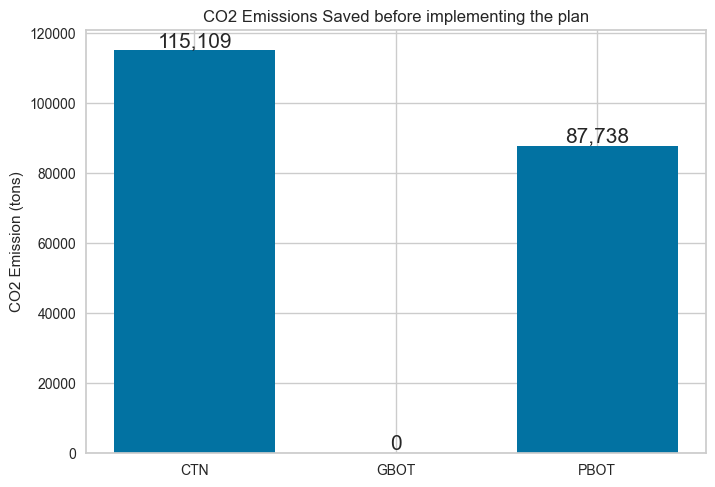

In [71]:
import matplotlib.pyplot as plt

labels = ['CTN', 'GBOT', 'PBOT']

plt.bar(labels, GHG_result_Not_Recycle)

plt.ylabel('CO2 Emission (tons)')
plt.title('CO2 Emissions Saved before implementing the plan')

for i, value in enumerate(GHG_result_Not_Recycle):
    formatted_value = "{:,.0f}".format(value)
    plt.text(i, value, formatted_value, ha='center', va='bottom', fontsize=15)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

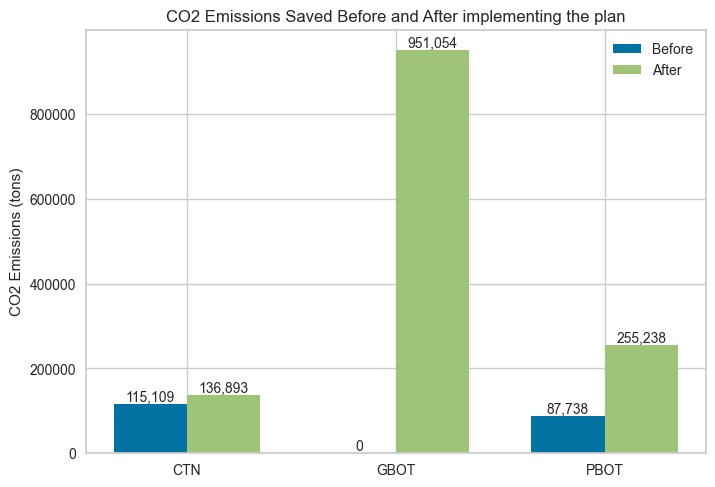

In [72]:
import matplotlib.pyplot as plt

labels = ['CTN', 'GBOT', 'PBOT']

x = range(len(labels))
bar_width = 0.35

plt.bar(x, GHG_result_Not_Recycle, width=bar_width, label='Before')
plt.bar([i + bar_width for i in x], GHG_result, width=bar_width, label='After')

plt.ylabel('CO2 Emissions (tons)')

for i, value in enumerate(GHG_result_Not_Recycle):
    plt.text(i, value, "{:,.0f}".format(value), ha='center', va='bottom', fontsize=10)
for i, value in enumerate(GHG_result):
    plt.text(i + bar_width, value, "{:,.0f}".format(value), ha='center', va='bottom', fontsize=10)

plt.xticks([i + bar_width / 2 for i in x], labels, fontsize=10)
plt.yticks(fontsize=10)

plt.legend()
plt.title('CO2 Emissions Saved Before and After implementing the plan')

plt.show()